In [1]:
import os
import cv2
import numpy as np

from utils.dataloader import DataLoader
from utils.vis import MatplotlibVisualizer
from utils.transforms import HairRemoval, Composer
from utils.segmentation import ThresholdingSegmentation
from descriptors.shape import HOGDescriptor
from descriptors.sift import SIFTDescriptor
from descriptors.texture import LBPDescriptor, GLCMDescriptor
from descriptors.color import ColorDescriptor, ColorLayoutDescriptor, ColorCooccurrenceMatrixDescriptor

In [2]:
## Classes
CLASSES = ['nevus', 'others']

## Work folfer
work_folder = os.getcwd()
data_folder = os.path.join(work_folder, '..', 'Data/Challenge1')

## Visualizer
matplotlib_visualizer = MatplotlibVisualizer()

In [3]:
dataloader = DataLoader(data_folder, 'train', 
                        shuffle=True, 
                        ignore_folders=['black_background', '.DS_Store'], 
                        max_samples=10, 
                        balance=True,
                        transforms=None)

In [4]:
def detect_keypoints_gloh(image, mask):
    """
    Detect keypoints inside the segmented lesion contour using GLOH (or SIFT/ORB as a proxy).
    Args:
    - image: The original RGB image.
    - mask: The segmentation mask of the lesion.
    
    Returns:
    - keypoints: List of keypoints inside the contour of the lesion.
    """
    # Convert the image to grayscale (needed for keypoint detection)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a SIFT detector (proxy for GLOH)
    detector = cv2.SIFT_create()  # You can also use ORB: cv2.ORB_create()
    
    # Detect keypoints on the full image
    keypoints = detector.detect(gray_image, None)
    
    # Filter keypoints to only include those inside the lesion contour
    keypoints_inside = [kp for kp in keypoints if mask[int(kp.pt[1]), int(kp.pt[0])] > 0]

    keypoints_image = cv2.drawKeypoints(image, keypoints_inside, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return keypoints_inside, keypoints_image

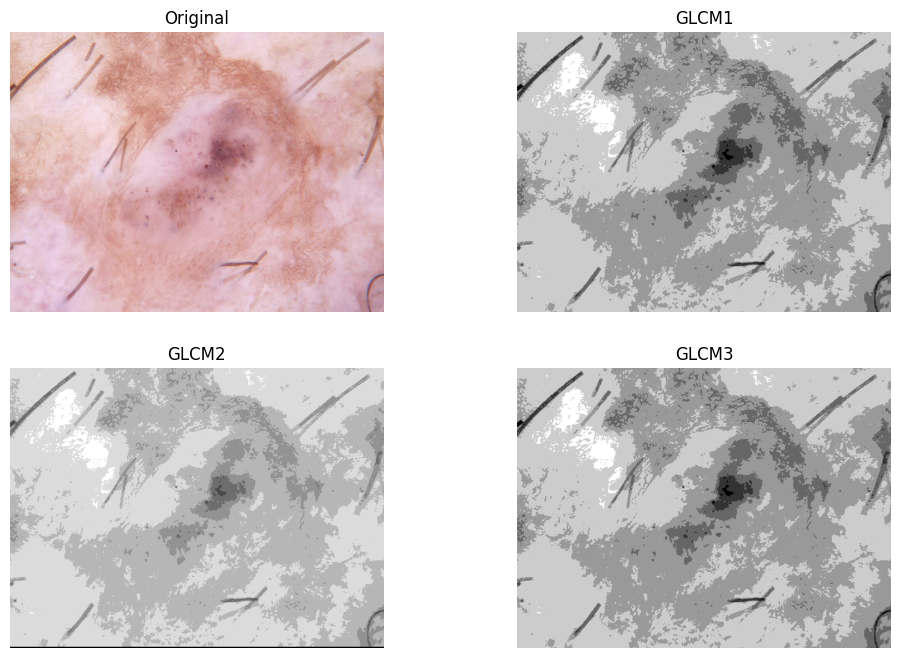

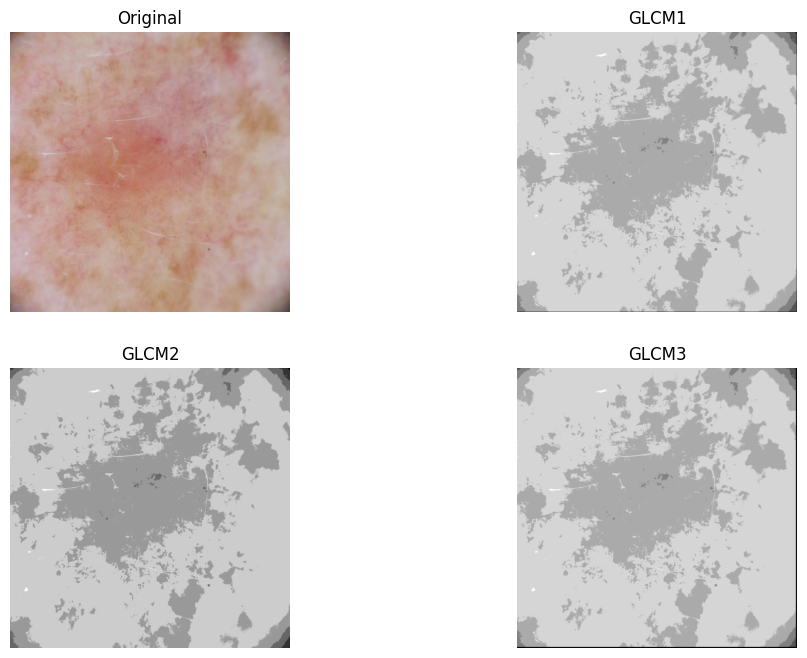

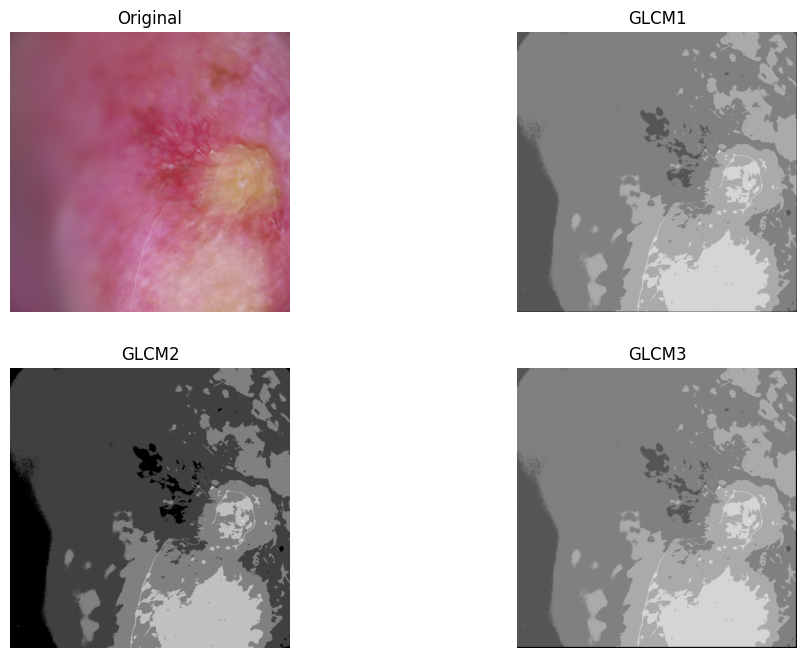

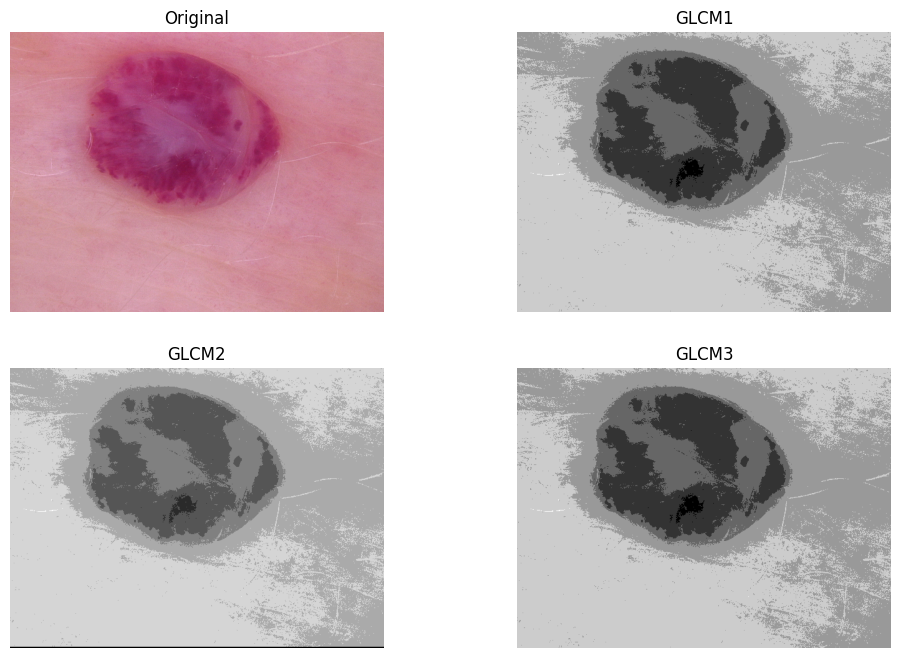

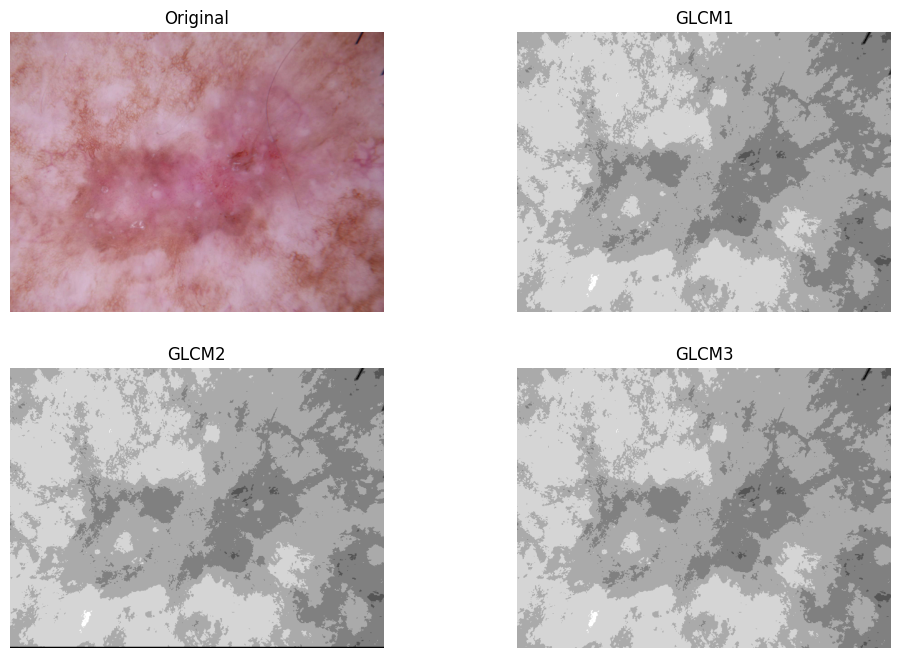

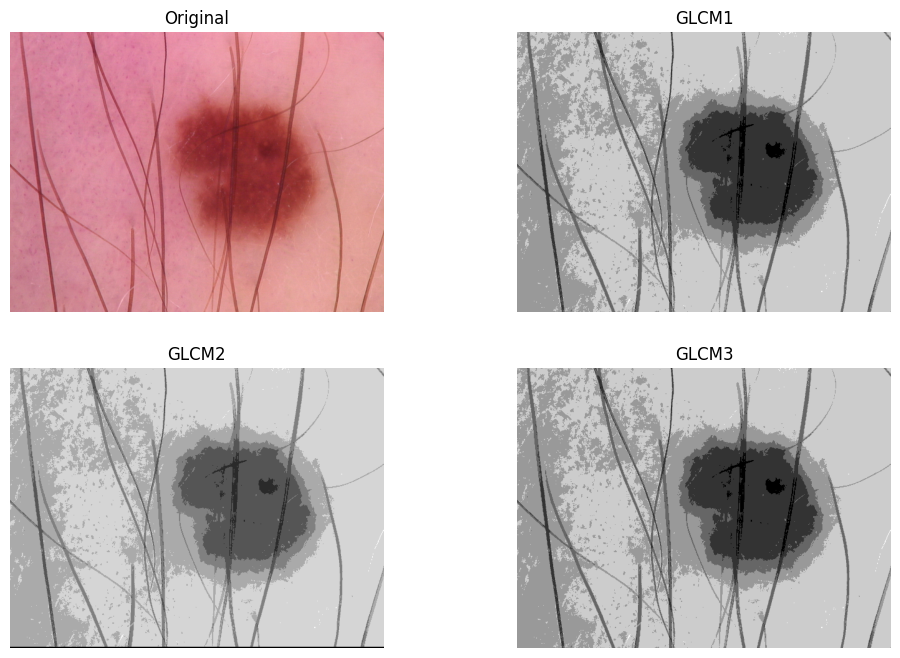

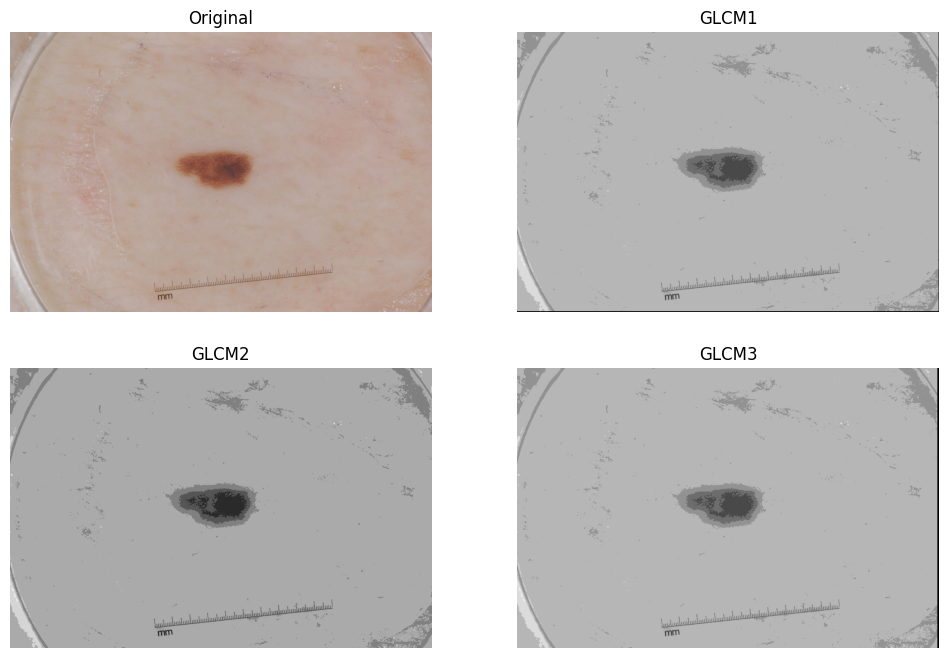

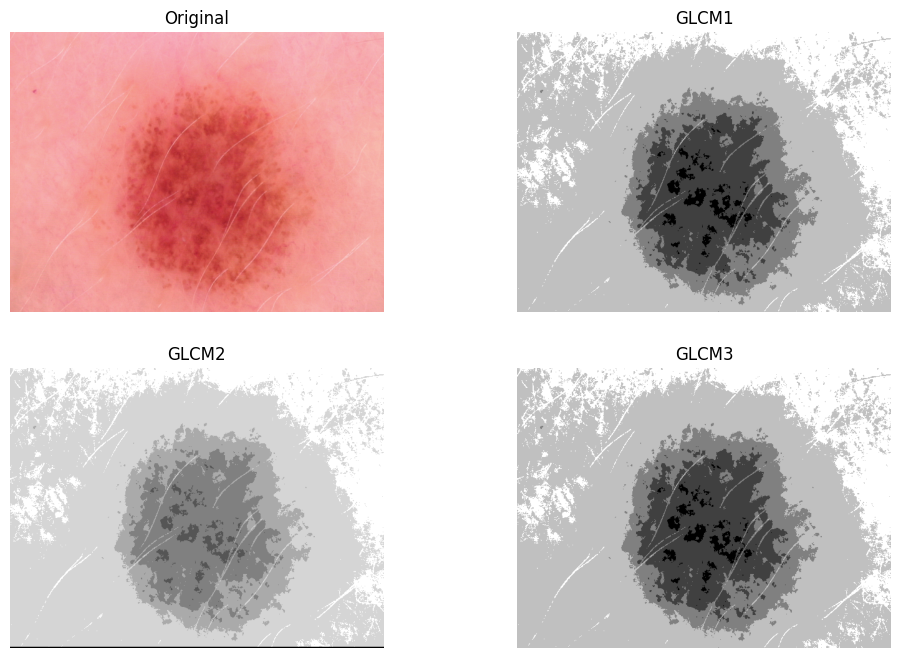

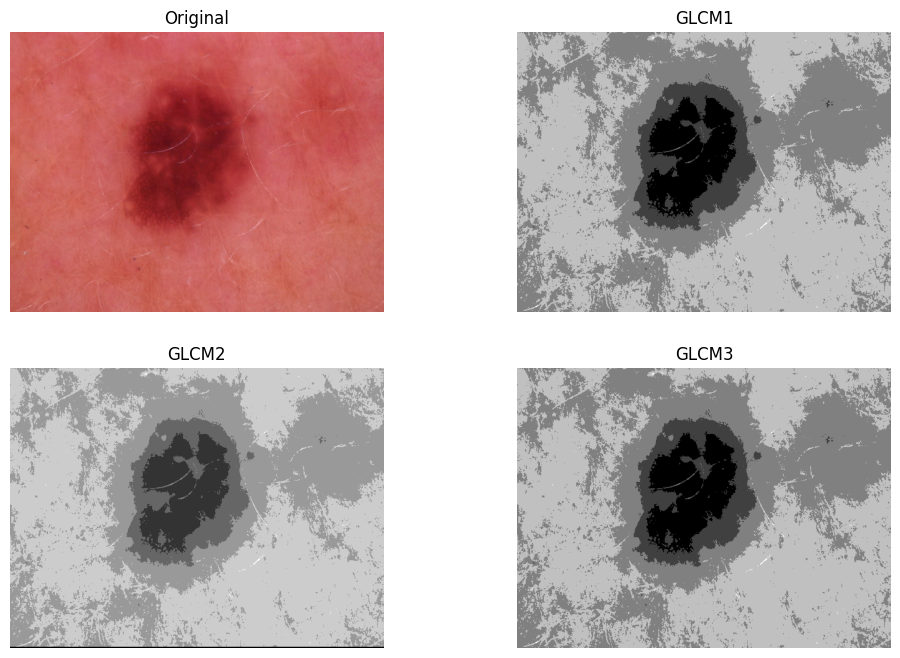

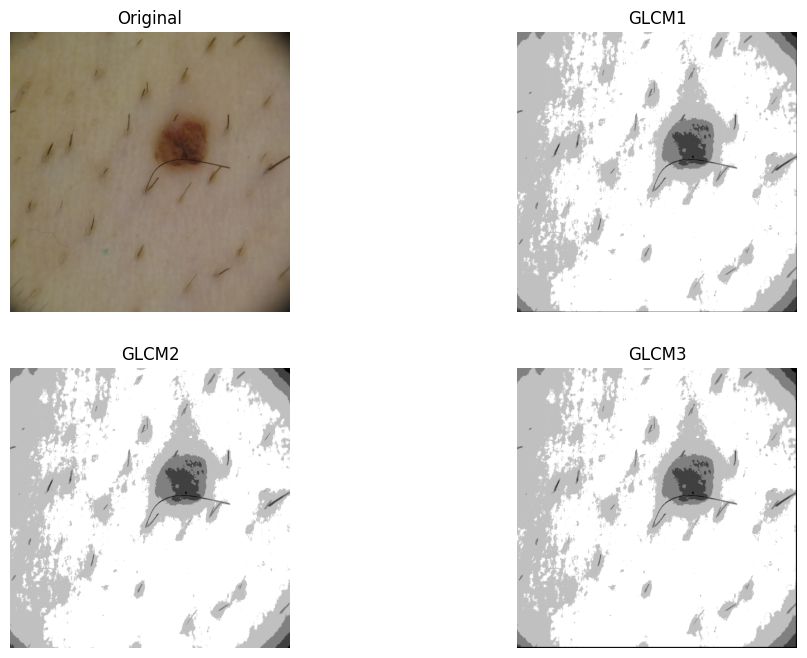

In [20]:
hair_removal = HairRemoval()
thresholding_segmentation = ThresholdingSegmentation()
lbp_descriptor = LBPDescriptor(radius=3, n_points=16, grid_x=3, grid_y=3, visualize=True)
glcm_descriptor1 = GLCMDescriptor(distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=8, visualize=True, grid_x=3, grid_y=3)
glcm_descriptor2 = GLCMDescriptor(distances=[1], angles=[0], levels=8, visualize=True, grid_x=4, grid_y=4)
glcm_descriptor3 = GLCMDescriptor(distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=8, visualize=True, grid_x=5, grid_y=5)


for i, (img, label, path) in enumerate(dataloader):
    hair_removal_img = hair_removal(img)
    thresholding_segmentation_img = thresholding_segmentation(hair_removal_img)
    thresholding_segmentation_img = (thresholding_segmentation_img / 255 - 1) * -255
    # Ensure the mask is of type uint8
    thresholding_segmentation_img = thresholding_segmentation_img.astype(np.uint8)
    # keypoints, keypoints_image = detect_keypoints_gloh(img, thresholding_segmentation_img)    
    # matplotlib_visualizer.show_multiple_images([img, thresholding_segmentation_img, keypoints_image], labels=['Original', 'Segmentation', 'Keypoints'])
    # lbps, lbp_img = lbp_descriptor.extract(img, mask=thresholding_segmentation_img)
    
    glcm1, glcm_img1 = glcm_descriptor1.extract(img, mask=None)
    glcm2, glcm_img2 = glcm_descriptor2.extract(img, mask=None)
    glcm3, glcm_img3 = glcm_descriptor3.extract(img, mask=None)
    matplotlib_visualizer.show_multiple_images([img, glcm_img1, glcm_img2, glcm_img3], labels=['Original', 'GLCM1', 'GLCM2', 'GLCM3'])
    if i > 10:
        break